In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
from common import (CFGTrainer, GaussianConditionalProbabilityPath,
                    LinearAlpha, LinearBeta, MNISTSampler)
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from unet_model import MNISTUNet

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps")

In [9]:
# Initialize probability path
path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = CFGTrainer(path = path, model = unet, eta=0.1)

# Train!
num_epochs = 5000
trainer.train(num_epochs = num_epochs, device=device, lr=1e-3, batch_size=250)

Training model with size: 4.715 MiB


Epoch 4999, loss: 0.128: : 5000it [20:18,  4.10it/s]


In [10]:
from common import CFGVectorFieldODE, EulerSimulator

100%|██████████| 99/99 [00:06<00:00, 15.32it/s]


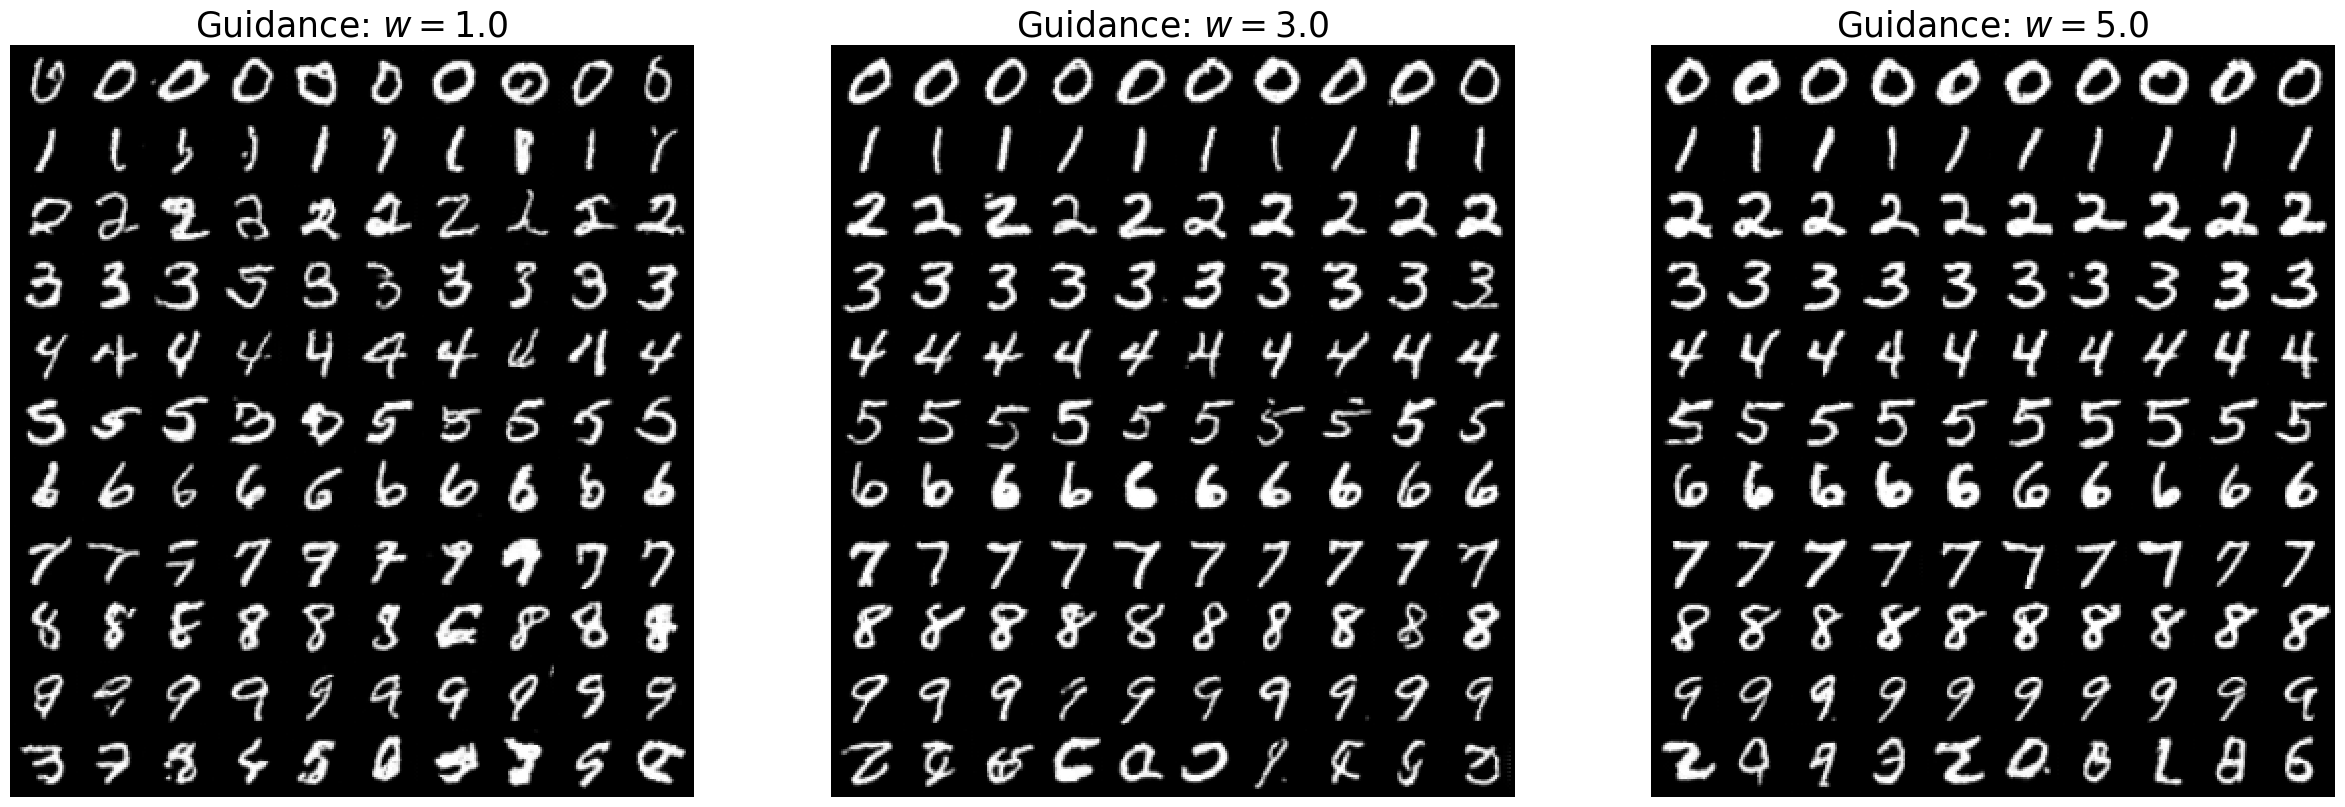

In [11]:
# Play with these!
samples_per_class = 10
num_timesteps = 100
guidance_scales = [1.0, 3.0, 5.0]

# Graph
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Sample initial conditions
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)

    # Simulate
    ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)
plt.show()